In [2]:
!pip install -q gdown
!pip install -q keras_tuner

In [3]:
import gdown  
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

from io import StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Reshape, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

import keras
import keras_tuner as kt  
from keras import layers
from keras_tuner.tuners import RandomSearch, BayesianOptimization
import seaborn as sns



# DATA UPLOAD AND PREPROCESSING

In [4]:
url = 'https://drive.google.com/uc?id=1f8wwVmV4JXc-iT4UH-RlYxTPQ0a1OFuj'
# filename
output = 'public_data.npz'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1f8wwVmV4JXc-iT4UH-RlYxTPQ0a1OFuj
From (redirected): https://drive.google.com/uc?id=1f8wwVmV4JXc-iT4UH-RlYxTPQ0a1OFuj&confirm=t&uuid=6f0d1c33-d615-49f0-bef0-efbc400a124d
To: /kaggle/working/public_data.npz
100%|██████████| 575M/575M [00:08<00:00, 69.9MB/s] 


'public_data.npz'

In [5]:
# Separate the images and the labels
dataset = np.load('public_data.npz', allow_pickle=True)
images = dataset["data"]
labels = dataset["labels"]
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
labels = np.unique(dataset["labels"], return_inverse=True)[1]

In [6]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)

print("zero images: %d\n one images: %d" % (counts_elements[0], counts_elements[1]))

zero images: 3199
 one images: 2001


In [7]:
# Normalize the images to the range [0, 1]
if images.max() > 1:  # Check if normalization is needed
    images = images / 255.0 

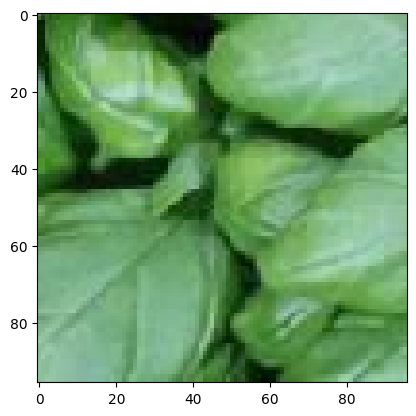

In [8]:
plt.imshow(images[1], interpolation='nearest')
plt.show()

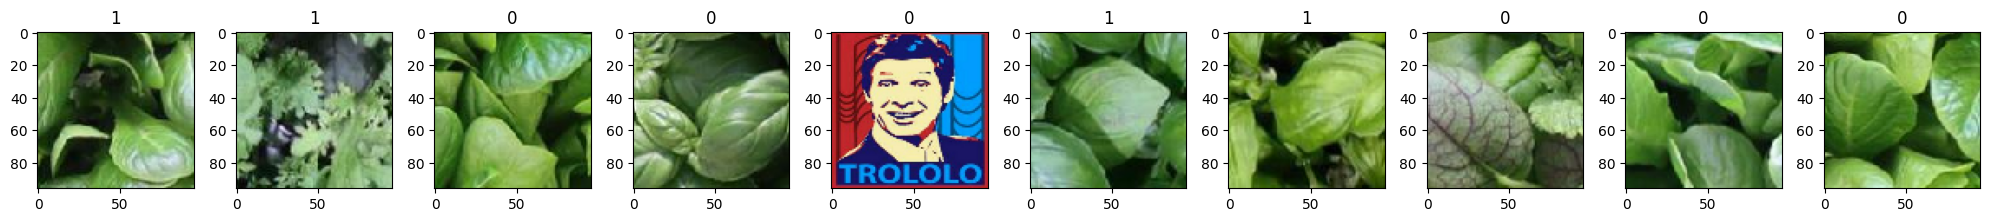

In [10]:
# Display a sample of images from the dataset
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    idx = np.random.randint(len(images))
    ax = axes[i % num_img]
    ax.imshow(images[idx])
    ax.set_title('{}'.format(labels[idx]))

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [7]:
# Cleaning the Dataset
flattened_images = images.reshape(images.shape[0], -1)
db = DBSCAN(eps=0.1, min_samples=10).fit(flattened_images)
labelss = db.labels_
n_clusters_ = len(set(labelss)) - (1 if -1 in labelss else 0)
n_noise_ = list(labelss).count(-1)
unique_elements, counts_elements = np.unique(labelss, return_counts=True)
print("  plants cluster: %d\n   shrek cluster:  %d\n    meme cluster:  %d" % (counts_elements[0], counts_elements[1], counts_elements[2]))

  plants cluster: 5004
   shrek cluster:  98
    meme cluster:  98


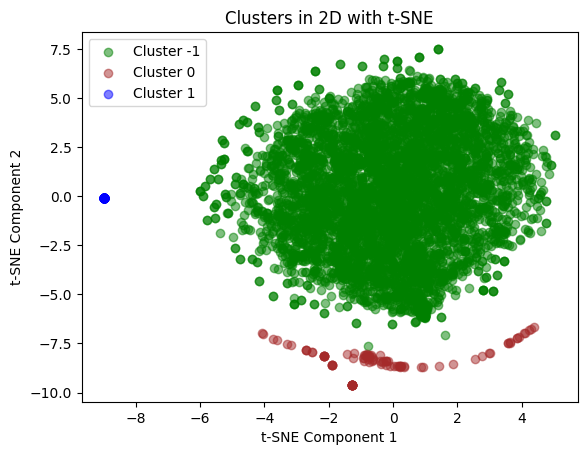

In [80]:
# t-SNE PLOTTING

# Reduce the dimensionality of the images to 2 components for 2D plotting
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(flattened_images)

# Define the colors for each cluster
cluster_colors = { -1: 'green', 0: 'brown', 1: 'blue'}

# Plot each cluster using t-SNE results
for cluster_label in np.unique(labelss):
    # Select the data points that belong to the current cluster
    in_cluster = labelss == cluster_label
    cluster_data = tsne_results[in_cluster]

    # Plot those data points with the cluster's color
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                c=cluster_colors[cluster_label], label=f'Cluster {cluster_label}', alpha=0.5)

# Label the axes and show the plot
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Clusters in 2D with t-SNE')
plt.legend()
plt.show()

In [8]:
# Masking
cluster_good_indices = np.where(labelss == -1)[0]
mask = np.zeros(len(labels), dtype=bool)
mask[cluster_good_indices] = True

# Apply the mask to both labels and images.
labels = labels[mask]
images = images[mask]

In [9]:
# Splitting in train test and validation
trainD, tempD, trainL, tempL = train_test_split(images, labels, test_size=0.20, random_state=42)
valD, testD, valL, testL = train_test_split(tempD, tempL, test_size=0.50, random_state=42)

# Now you have train, validation, and test sets
print("Training Data Shape:", trainD.shape)
print("Validation Data Shape:", valD.shape)
print("Test Data Shape:", testD.shape)

Training Data Shape: (4002, 96, 96, 3)
Validation Data Shape: (500, 96, 96, 3)
Test Data Shape: (501, 96, 96, 3)


# TRANSFER LEARNING RESNET50

In [10]:
inputs = keras.Input(shape=(96, 96, 3))
x = layers.Resizing(224, 224, interpolation="nearest")(inputs)
x = layers.RandomRotation(0.011, fill_mode="nearest")(x)
x = layers.RandomTranslation(0.091, 0.091, fill_mode="nearest")(x)
x = layers.RandomZoom(0.011, fill_mode="nearest")(x)
base_M = keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_M.trainable = False
x = base_M(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=800, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=800, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=800, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0005)
M.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
M.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │     1,639,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 800)            │       640,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 800)            │       640,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,486,401 (101.04 MB)

 Trainable params: 2,921,601 (11.15 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [12]:
filename = 'plant_TL.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(trainD, trainL, batch_size=32, epochs=100, validation_data=(valD , valL), verbose=0,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])


Epoch 1: val_accuracy improved from -inf to 0.81600, saving model to plant_TL.keras

Epoch 2: val_accuracy did not improve from 0.81600

Epoch 3: val_accuracy did not improve from 0.81600

Epoch 4: val_accuracy improved from 0.81600 to 0.83600, saving model to plant_TL.keras

Epoch 5: val_accuracy did not improve from 0.83600

Epoch 6: val_accuracy did not improve from 0.83600

Epoch 7: val_accuracy did not improve from 0.83600

Epoch 8: val_accuracy did not improve from 0.83600

Epoch 9: val_accuracy did not improve from 0.83600

Epoch 10: val_accuracy did not improve from 0.83600

Epoch 11: val_accuracy improved from 0.83600 to 0.84200, saving model to plant_TL.keras

Epoch 12: val_accuracy improved from 0.84200 to 0.84400, saving model to plant_TL.keras

Epoch 13: val_accuracy did not improve from 0.84400

Epoch 14: val_accuracy did not improve from 0.84400

Epoch 15: val_accuracy did not improve from 0.84400

Epoch 16: val_accuracy improved from 0.84400 to 0.85200, saving model to

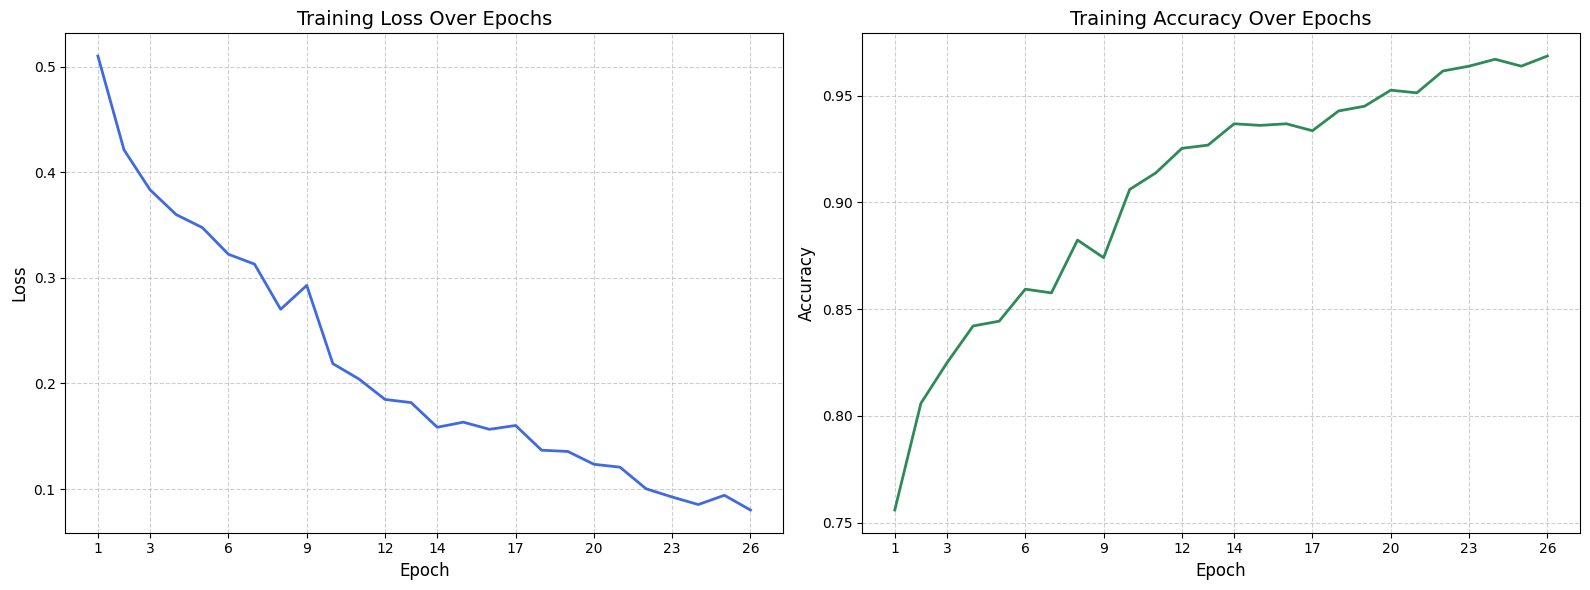

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
xx = np.arange(1, len(H.history['loss']) + 1)
# Plot 1: Loss
ax = axes[0]
ax.plot(xx, H.history['loss'], color='royalblue', linewidth=2)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Over Epochs', fontsize=14)
ax.set_xticks(np.linspace(1, len(H.history['loss']), 10, dtype=int))
# Plot 2: Accuracy
ax = axes[1]
ax.plot(xx, H.history['accuracy'], color='seagreen', linewidth=2)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training Accuracy Over Epochs', fontsize=14)
ax.set_xticks(np.linspace(1, len(H.history['accuracy']), 10, dtype=int))

plt.tight_layout()
plt.show()

In [14]:
 # Evaluate model
trainLoss, trainAccuracy = M.evaluate(trainD, trainL, verbose=False)
valLoss, valAccuracy = M.evaluate(valD, valL, verbose=False)
testLoss, testAccuracy = M.evaluate(testD, testL, verbose=False)
# Print the results
print(f"Training Loss: {trainLoss:.4f}, Training Accuracy: {trainAccuracy:.4f}")
print(f"Validation Loss: {valLoss:.4f}, Validation Accuracy: {valAccuracy:.4f}")
print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.4f}")

Training Loss: 0.0536, Training Accuracy: 0.9795
Validation Loss: 0.6363, Validation Accuracy: 0.8320
Test Loss: 0.6327, Test Accuracy: 0.8423


In [16]:
predictions = M.predict(testD)
predicted_classes = (predictions > 0.5).astype(int).flatten()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


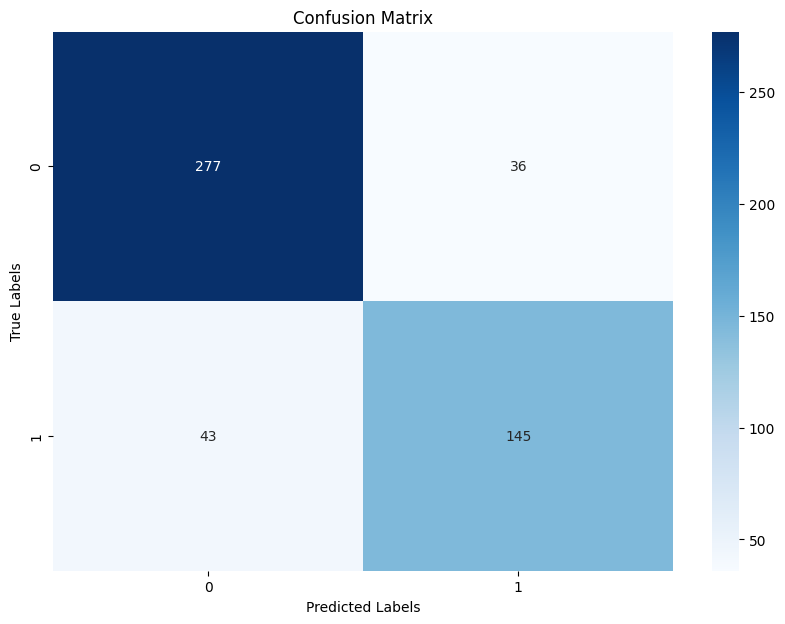

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(testL, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(testL), 
            yticklabels=np.unique(testL))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# FINE TUNING

In [17]:
M = keras.models.load_model('plant_TL.keras')

In [18]:
start_unfreezing = False  
for layer in base_M.layers:
    if 'conv5_block2_out' in layer.name:
        start_unfreezing = True  # Start unfreezing from this layer onward
    if start_unfreezing and not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

opt = keras.optimizers.Adam(learning_rate=1e-5)
M.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


In [19]:
filename = 'plant_FT.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(trainD, trainL, batch_size=64, epochs=100, validation_data=(valD, valL), verbose=0,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])


Epoch 1: val_accuracy improved from -inf to 0.85200, saving model to plant_FT.keras

Epoch 2: val_accuracy did not improve from 0.85200

Epoch 3: val_accuracy did not improve from 0.85200

Epoch 4: val_accuracy did not improve from 0.85200

Epoch 5: val_accuracy did not improve from 0.85200

Epoch 6: val_accuracy did not improve from 0.85200

Epoch 7: val_accuracy did not improve from 0.85200

Epoch 8: val_accuracy did not improve from 0.85200

Epoch 9: val_accuracy did not improve from 0.85200

Epoch 10: val_accuracy did not improve from 0.85200

Epoch 11: val_accuracy did not improve from 0.85200


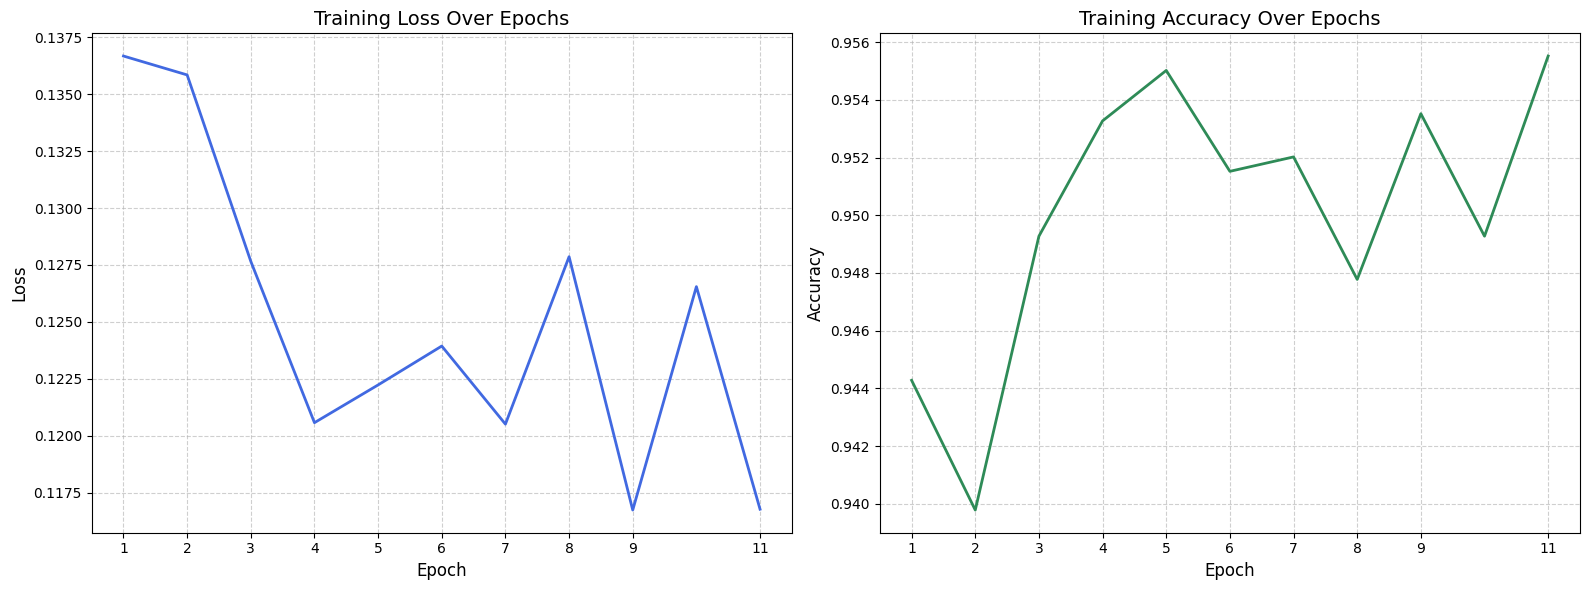

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
xx = np.arange(1, len(H.history['loss']) + 1)
# Plot 1: Loss
ax = axes[0]
ax.plot(xx, H.history['loss'], color='royalblue', linewidth=2)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Over Epochs', fontsize=14)
ax.set_xticks(np.linspace(1, len(H.history['loss']), 10, dtype=int))
# Plot 2: Accuracy
ax = axes[1]
ax.plot(xx, H.history['accuracy'], color='seagreen', linewidth=2)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training Accuracy Over Epochs', fontsize=14)
ax.set_xticks(np.linspace(1, len(H.history['accuracy']), 10, dtype=int))

plt.tight_layout()
plt.show()

In [21]:
 # Evaluate model
trainLoss, trainAccuracy = M.evaluate(trainD, trainL, verbose=False)
valLoss, valAccuracy = M.evaluate(valD, valL, verbose=False)
testLoss, testAccuracy = M.evaluate(testD, testL, verbose=False)
# Print the results
print(f"Training Loss: {trainLoss:.4f}, Training Accuracy: {trainAccuracy:.4f}")
print(f"Validation Loss: {valLoss:.4f}, Validation Accuracy: {valAccuracy:.4f}")
print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.4f}")

Training Loss: 0.0900, Training Accuracy: 0.9665
Validation Loss: 0.5311, Validation Accuracy: 0.8480
Test Loss: 0.5106, Test Accuracy: 0.8403


In [22]:
predictions = M.predict(testD)
predicted_classes = (predictions > 0.5).astype(int).flatten()

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step


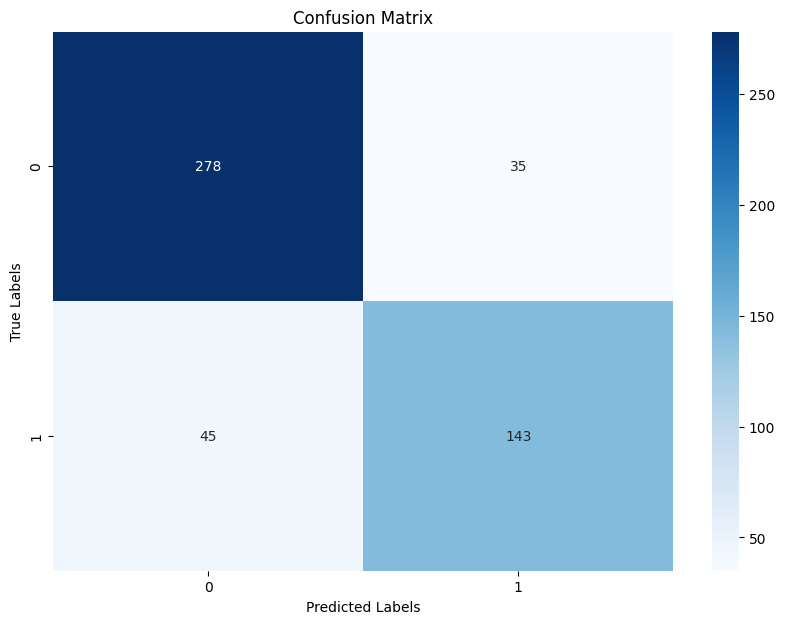

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(testL, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(testL), 
            yticklabels=np.unique(testL))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()